<a href="https://colab.research.google.com/github/Dev-ZC/Multi-Agent-LLM-Research/blob/main/Multi_Agent_LLM_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports/Environment

In [ ]:
!pip install langchain
!pip install crewai
!pip install openai

# Install the main crewAI package and the tools package
# that includes a series of helpful tools for your agents
#!pip install 'crewai[tools]'

# Alternatively, you can also use:
#!pip install crewai crewai-tools

In [ ]:
import os
from openai import OpenAI

from google.colab import userdata
from langchain.agents import Tool
from langchain.agents import load_tools

from crewai import Agent, Task, Process, Crew
from langchain.utilities import GoogleSerperAPIWrapper

# Set the API key as an environment variable
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY_2')
os.environ["SERPER_API_KEY"] = userdata.get('SERPER_KEY')

ModuleNotFoundError: No module named 'langchain'

# ChatGPT Output Example (Normal LLM)

*   Utilizes a singular LLM to generate text
*   Results in limited accuracy and capabilities (compared to multi-agent models)



In [ ]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY_2"))

print("What would you like to ask?")
userInput = input()

completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": userInput
        }
    ]
)

print("")
print("ChatGPT Response: ")
print(completion.choices[0].message.content)

What would you like to ask?
Could you tell about france?

ChatGPT Response: 
Certainly! France is a country located in Western Europe, known for its rich history, culture, and influence on global affairs. Here are some key aspects of France:

### Geography
- **Location**: France is bordered by Belgium and Luxembourg to the northeast, Germany, Switzerland, and Italy to the east, and Spain to the southwest. It also has coastlines along the Atlantic Ocean, the English Channel, and the Mediterranean Sea.
- **Regions**: France is divided into 18 administrative regions, with 13 regions on the mainland and 5 overseas regions. Notably, Paris, the capital, is in the Île-de-France region.

### History
- **Ancient and Medieval History**: The region has a rich history that dates back to prehistoric times. Historically known as Gaul, it was inhabited by Celtic tribes before becoming part of the Roman Empire. It became the center of Frankish power in the early Middle Ages.
- **Modern History**: Fran

# Autonomous and Multi-Agentic Demo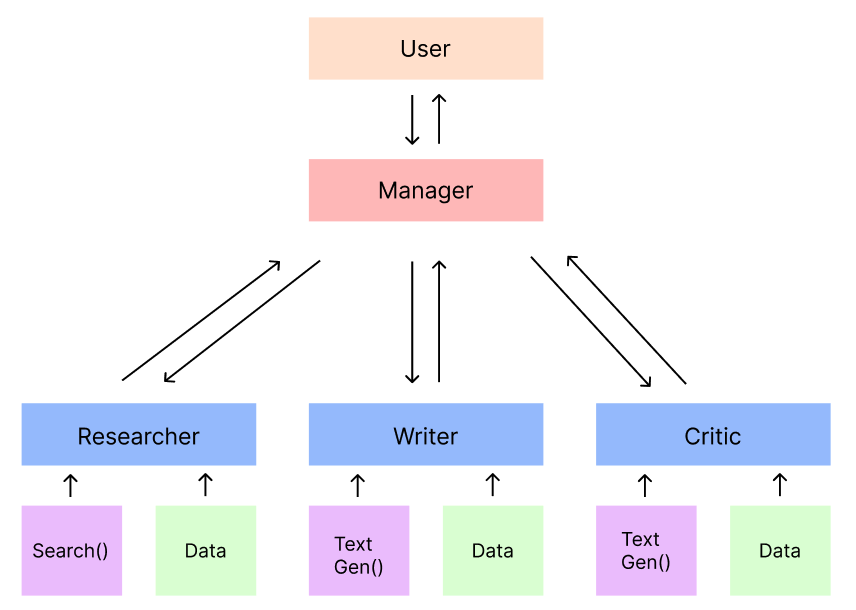

In [ ]:
# Initialize the search tool using Google Serper API
search = GoogleSerperAPIWrapper()

search_tool = Tool(
    name="Scrape google searches",
    func=search.run,
    description="useful for when you need the agent to search the internet for specific information",
)

# Load human tools if needed
human_tools = load_tools(["human"])

# To Load GPT-4
api = os.environ.get("OPENAI_API_KEY")

# Define the Explorer Agent, which searches based on dynamic input topics
explorer = Agent(
    role="Senior Researcher",
    goal="Find and explore relevant projects, companies, or research based on any input topic.",
    backstory="""You are an Expert strategist and researcher, skilled at identifying emerging trends in any field.
    You excel at using scraped data from various online sources to create detailed reports on the most relevant and exciting projects or companies.
    You will dynamically explore topics given by the user.""",
    verbose=True,
    allow_delegation=False,
    tools=[search_tool],
)

# Task for the explorer agent based on user input
def generate_explorer_task(input_topic):
    return Task(
        description=f"""Explore and summarize relevant and emerging projects, tools, companies, or research on the topic "{input_topic}".
        Use ONLY scraped data to generate the report. Your final answer MUST be a full analysis report, text only.
        The report should contain 5-10 exciting projects, tools, or research findings. Each entry should have 3 sentences describing its significance
        in relation to the topic '{input_topic}'.""",
        expected_output="A detailed analysis report based on the scraped data.",
        agent=explorer,
    )

# Define the Writer Agent
writer = Agent(
    role="Senior Technical Writer",
    goal="Write engaging and informative blog posts about any input topic using simple, layman vocabulary.",
    backstory="""You are an Expert Writer in various fields, skilled at making complex information digestible. You write concisely
    but still captivate the reader. The blog posts are engaging, straightforward, and use layman terms while staying informative and compelling.""",
    verbose=True,
    allow_delegation=True,
)

# Task for the writer agent to create a blog from explorer's report
def generate_writer_task(report, input_topic):
    return Task(
        description=f"""Write a short blog article summarizing the report on '{input_topic}'.
        The blog should have a short, impactful headline and be divided into at least three paragraphs.
        The style should be concise, fun, and technical but in layman’s terms for a general audience.
        Name specific exciting projects, apps, or companies in relation to '{input_topic}', and include markdown links to resources.
        You must include links to all information you referenced.
        """,
        expected_output="A short blog post based on the report.",
        agent=writer,
    )

# Define the Critic Agent
critic = Agent(
    role="Expert Writing Critic",
    goal="Ensure blog posts are compelling, concise, and follow the proper format.",
    backstory="""You are a critical and thoughtful editor, focused on improving the readability and impact of technical writing.""",
    verbose=True,
    allow_delegation=True,
)

# Task for the critic agent to review the writer's blog
def generate_critic_task(blog_post, input_topic):
    return Task(
        description=f"""Review, edit, and rewrite the blog post on '{input_topic}'. Ensure that it follows the markdown format:
        ## Final Draft: [Title of post](link to project)
        Write a more cohesive and in depth blog post and include links to all information you discussed""",
        expected_output="A refined and polished blog post.",
        agent=critic,
    )

# Now, instantiate the crew of agents and set up the process for task completion
def run_workflow(input_topic):
    # Create tasks dynamically based on the user input topic
    task_report = generate_explorer_task(input_topic)
    task_blog = generate_writer_task(None, input_topic)
    task_critique = generate_critic_task(None, input_topic)

    # Create the crew with the dynamic agents and tasks
    crew = Crew(
        agents=[explorer, writer, critic],
        tasks=[task_report, task_blog, task_critique],
        verbose=1,
        process=Process.sequential,  # Ensure that tasks are executed in sequence with outputs passed to the next agent
    )

    # Kickoff the process and gather the results
    result = crew.kickoff()

    print("######################")
    print(result)

# Example run of the workflow
input_example = "The future of quantum computing in 2024"
user_input_topic = input()
run_workflow(user_input_topic)

Could you write about car batteries


# Agent: Senior Researcher
## Task: Explore and summarize relevant and emerging projects, tools, companies, or research on the topic "Could you write about car batteries".
        Use ONLY scraped data to generate the report. Your final answer MUST be a full analysis report, text only.
        The report should contain 5-10 exciting projects, tools, or research findings. Each entry should have 3 sentences describing its significance
        in relation to the topic 'Could you write about car batteries'.


# Agent: Senior Researcher
## Thought: I need to gather current and relevant information about emerging projects, tools, companies, or research related to car batteries. This data will help in forming a comprehensive analysis report.
## Using tool: Scrape google searches
## Tool Input: 
"{\"tool_input\": \"emerging projects tools companies research car batteries 2023\"}"
## Tool Output: 
Aionics is working to use AI tools to help researchers find better battery chemistries faster. The